In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import namedtuple
from scipy import stats
from sklearn import metrics
import pickle
%matplotlib inline

Consider a mixture of Bernoullis with a Dirichlet prior on
the mixture weights π ∼ Dir(α) and a Beta prior on the mean parameter µkj ∼ β(α, β).
Use α = 1 and choose an appropriate (α, β) pair for your prior (back this up). Note that
the M step for the mean is given in problem 2 (Murphy 11.3). Cluster the MNIST training
dataset we used from homework 1 (http://pjreddie.com/media/files/mnist_train.
csv) using this mixture with 10 components. Provide a convergence plot of the MAP
objective (which must monotonically increase) and plot the mean images for each component.
Do the clusters roughly correspond to different digits (back this up somehow)?


print("Hello")

In [4]:
def eMalgo(A, n, theta, cost, likelihood, m_step, max_iter=1000, print_freq =10):
    """ 
    A = data
    theta = weights
    n = number of distributions
    likelihood = input distribution
    """
    ## Setup the shapes of our values
    r =  np.ones((A.shape[0],n)) / n
    pi = np.ones(n)/ n
    costs = [cost(A, r, pi, theta)]
    
    i = 0
    # loop through our EM step
    while i < max_iter:
        if i % print_freq == 0:
            print("iteration #: {}\n with cost: {}".format(i, costs[-1]))
        ## E-Step gogo
        r = likelihood(A, theta) * pi
        r = r / np.sum(r, axis=1)[:, np.newaxis] # np.newaxis converts a row vector to a column vector
        ## M-Step gogo
        pi, theta = m_step(A, r)
        costs.append(cost(A, r, pi, theta))
        i += 1
    return (costs, r, pi, theta)

In [5]:
def bmm(A, n, prior_alpha, prior_a, prior_b, max_iter=1000):
    """
    A = data
    n = number of distributions
    prior_alpha = given
    prior_a = for beta param
    prior_b = for beta param
    max_iter = range for loop
    """
    # generate the S_0 as the pooled variance in dimension j
    S_0 = np.diag(np.power(np.std(A, axis=0),2)) / np.power(n , (1/A.shape[1]))
    
    # create our named tuple, with bernoulli means
    objectHolder = namedtuple("bernoulli", "mean")
    theta = objectHolder(mean = A[:n*np.floor(A.shape[0]/n)].reshape( n, -1, X.shape[1],).mean(axis=1),)
    
    # Create the denominator of the MAP estimate on the mixture weights
    denominator = A.shape[0] +  np.sum(prior_alpha) - n
    
    
    # finish our maximization step
    def m_step(A, r):
        
        # get the sum of the columns
        sum_r = np.sum(r, axis = 0)
        
        # generate our MAP estimate
        pi = (sum_r + prior_alpha - 1) / denominator
        
        # generate mu maximization
        mu = (((A[:,:, np.newaxis] * r[:, np.newaxis,:]).sum(axis=0)  + prior_a - 1)/(sum_r + prior_a + prior_b - 2)).T
        return pi, objectHolder(mean=mu)
    
    ## Set up the likelihood.
    # 1. create the shape
    # 2. loop through
    def likelihood(A, theta):
        # shape num. of examples by n distributions
        ll = np.tile(theta.mean.T, (A.shape[0], 1, 1))
        
        # for each distribution, take the MVN w. respect to the generated theta values
        ll[A == 0] = 1 - ll[A == 0]
        ll = ll.prod(axis = 1)
        
        return ll
      
    def cost(A, r, pi, theta):
        # combine all the terms to produce the expected complete data log-likelihood
        
        # generate our likelihood term
        likelihood_term = r*np.log(likelihood(A, theta))
        likelihood_term = likelihood_term[r > 1e-12].sum()
    
        #generate our log_prior term
        log_prior = np.log(stats.beta.pdf(theta.mean, prior_a, prior_b,)).sum() + np.log(
            stats.dirichlet.pdf(pi, alpha=prior_alpha))
        
        # generate our distribution prior term
        dist_prior = (r * np.log(pi)[np.newaxis,:]).sum()
        
        return likelihood_term + log_prior + dist_prior
    
    return eMalgo(A, n, theta, cost, likelihood, m_step, max_iter, 10)
    

In [6]:
train = pickle.load(open('data.pkl', 'rb'))
X= train.iloc[:,1:].as_matrix()
X = (X > X[X>0].mean()).astype(float)
y = train.iloc[:, 0].as_matrix()

In [10]:
n = 10
cost, r, pi, theta = bmm(X[ np.random.randint(0, X.shape[0], (int(10000),))], n, prior_alpha = np.ones(10), prior_a=1, prior_b=1, max_iter=100, print_freq=10)

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:45: RuntimeWarning: divide by zero encountered in log


iteration #: 0
 with cost: -inf


C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:45: RuntimeWarning: invalid value encountered in multiply


iteration #: 10
 with cost: -1571432.8901549326
iteration #: 20
 with cost: -1560023.7209315228
iteration #: 30
 with cost: -1558804.4078077585
iteration #: 40
 with cost: -1557809.720497304
iteration #: 50
 with cost: -1557546.2127986422
iteration #: 60
 with cost: -1557504.5848071408
iteration #: 70
 with cost: -1557495.7955758674
iteration #: 80
 with cost: -1557495.297031256
iteration #: 90
 with cost: -1557495.2423850202


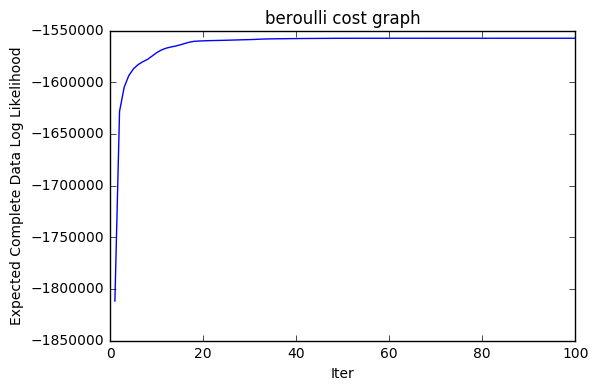

In [18]:
plt.plot(cost)
plt.title("beroulli cost graph")
plt.xlabel("Iter")
plt.ylabel("Expected Complete Data Log Likelihood")

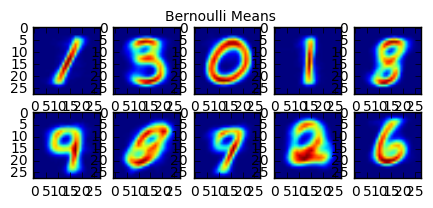

In [19]:
def plot_image(img):
    plt.imshow(img.reshape(28,28))

plt.figure(figsize=(5,2))
for i in range(10):
    plt.subplot(2,5,i+1)
    plot_image(theta.mean[i])
plt.suptitle("Bernoulli Means")

Yes, as we can see the red areas, certain clusters of points seems to correspond with different digits.